In [4]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [6]:
current_directory = os.getcwd()
current_directory
new_directory = "/Users/cl/Downloads/CSE 6240/final project"
os.chdir(new_directory)

In [8]:
data = pd.read_csv("Reviews.csv")

Define the helper function

In [18]:
#keep only the number of user and item bigger than 10
def data_clean(df, feature, m):
    count = df.groupby(feature).size()
    valid_items = count[count > m].index
    return df[df[feature].isin(valid_items)]

def data_clean_sum(df, features, m):
    df['#Products'] = df.groupby('ProductId')['ProductId'].transform('count')
    df['#Users'] = df.groupby('UserId')['UserId'].transform('count')
    
    while df[features[0]].value_counts(ascending=True).iloc[0] < m or df[features[1]].value_counts(ascending=True).iloc[0] < m:
        df = data_clean(df, features[0], m)
        df = data_clean(df, features[1], m)
        
    return df

Generate the user item table

In [43]:
def load_data(file_path):
    print("Loading data...")
    df = pd.read_csv(file_path)
    df['datetime'] = pd.to_datetime(df.Time, unit='s')
    return df

def preprocess_data(df, min_count):
    raw_data = data_clean_sum(df, ['ProductId', 'UserId'], min_count)
    #mmake numerical representations of the user and product IDs
    raw_data['uid'] = pd.factorize(raw_data['UserId'])[0]
    raw_data['pid'] = pd.factorize(raw_data['ProductId'])[0]

    return raw_data

def create_datasets(raw_data):
    X1 = raw_data.loc[:, ['uid', 'pid']]
    # give reviews that found useful by more people higher weight
    weight = raw_data.HelpfulnessNumerator / (raw_data.HelpfulnessDenominator + 1e-8)
    y = raw_data.Score * weight
    #y = raw_data.Score

    y.name = 'ScoreWeighted'  # Set a name for the 'y' Series
    X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=2017)
    train = np.array(X1_train.join(y_train))
    test = np.array(X1_test.join(y_test))

    return train, test, X1, y

def create_user_item_table(data_mixed, total_u, total_p):
    table = np.zeros([total_u, total_p])
    z = np.array(data_mixed)
    #make sure that it will keep the highest value of the product if user give multiole values of one product
    for line in z:
        u, p, s = line
        u, p = int(u), int(p)
        if table[u][p] < s:
            table[u][p] = s

    return table

def data():
    file_path = '/Users/cl/Downloads/CSE 6240/final project/Reviews.csv'
    df = load_data(file_path)
    raw_data = preprocess_data(df, 10)
    train, test, data_mixed, y = create_datasets(raw_data)
    
    pid2PID = raw_data.ProductId.unique()
    total_p = data_mixed['pid'].unique().shape[0]
    total_u = data_mixed['uid'].unique().shape[0]
    
    table = create_user_item_table(data_mixed.join(y), total_u, total_p)
    print("The table's shape is:")
    print(table.shape)
    
    return data_mixed, total_u, total_p, pid2PID, train, test, table, raw_data

z, total_u, total_p, pid2PID, train, test, table, raw_data = data()


Loading data...
The table's shape is:
(3666, 1102)


Evaluation function

In [92]:
def caculate_mse(x):
    true_rating_train=[]
    predicted_train=[]
    for line in train:
        u,p,s = line
        true_rating_train.append(s)
        predicted_train.append(x[u,p])
    MSE_train_sample = mean_squared_error(true_rating_train,predicted_train)
    true_rating_test = []
    predicted_test = []
    for line in test:
        u,p,s = line
        true_rating_test.append(s)
        predicted_test.append(x[u,p])
    MSE_test_sample = mean_squared_error(true_rating_test,predicted_test)
    print('the in sample MSE = {} \nthe out sample MSE = {}'.format(MSE_train_sample,MSE_test_sample))
    return MSE_train_sample,MSE_test_sample

In [96]:
def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')


def drawcm(y_pred,y_test =test ,title=''):
    print('caculating cm..')
    y1=[]
    y2=[]
    for line in y_test:
        u,p,s = line
        y1.append(s)
        y2.append(y_pred[u,p])
    temp1 = []
    temp2 = []
    for i in range(len(y1)):
        if np.array(y1)[i] >= 4:
            temp1.append(1)
        elif np.array(y1)[i] <= 2:
            temp1.append(0)
        else:
            temp1.append(0)
        if y2[i] >= 4:
            temp2.append(1)
        elif y2[i] <= 2:
            temp2.append(0)
        else:
            temp2.append(0)
    cm = confusion_matrix(temp1,temp2)
    plt.figure()
    plot_confusion_matrix(cm, classes=['not','recommand'], normalize=True,
                          title=title)
    plt.show()



In [97]:
def rec(result, uid, n, rawId=False):
    if uid in range(total_u):
        # Get the indices of the top n recommended products for user uid
        top_N_indices = np.argsort(result[uid])[-n:][::-1]
        
        # Print the top n recommended products
        print(f'The top {n} recommended products for user {uid} are: {top_N_indices}')
        
        # If rawId is True, print the real product IDs
        if rawId:
            real_ids = pid2PID[top_N_indices]
            print(f'The real IDs are: {real_ids}')
    else:
        print('This user has not bought anything, please use other methods.')
    
    return top_N_indices

the in sample MSE = 2.181532608112232 
the out sample MSE = 2.2582779695854374
caculating cm..
Normalized confusion matrix
[[0.42401961 0.57598039]
 [0.34159378 0.65840622]]


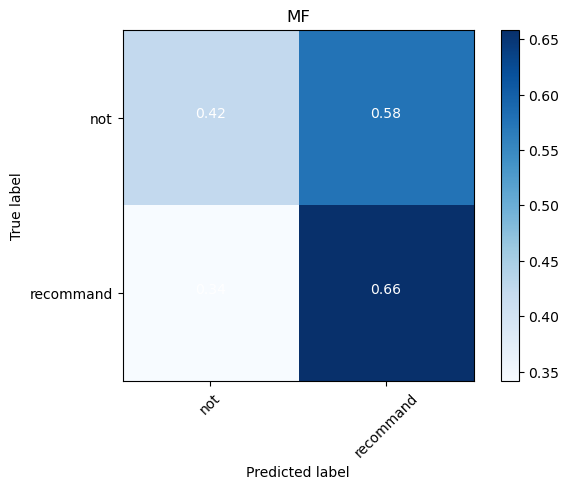

the top10 recommanded products for user 10 is [ 644  151  455   52 1072 1051  127 1067  106    0]
the real ID is ['B0058AMYTC' 'B00472I5A4' 'B0058AMY10' 'B0058AMY74' 'B001SAXPEO'
 'B006WYSFZK' 'B000G6MBUA' 'B004728MI4' 'B0012XBD7I' 'B000G6RYNE']


array([ 644,  151,  455,   52, 1072, 1051,  127, 1067,  106,    0])

In [98]:
from sklearn.metrics.pairwise import pairwise_distances
def cf(table = table,distance = 'cosine'):
    user_similarity = pairwise_distances(table, metric=distance)
    item_similarity = pairwise_distances(table.T, metric=distance)
    sc = MinMaxScaler(feature_range=(1,5))
    #use the hybrid method
    #R_pred = S_users * R * S_items*alpha*(1-alpha)
    a = sc.fit_transform(0.25*np.dot(user_similarity,table).dot(item_similarity))
    return a
result =cf()
caculate_mse(result)
drawcm(result,title='MF')
rec(result, 10,10,rawId= True)

the in sample MSE = 9.246699513579118 
the out sample MSE = 9.208863167941972
caculating cm..
Normalized confusion matrix
[[0.99836601 0.00163399]
 [0.99722338 0.00277662]]


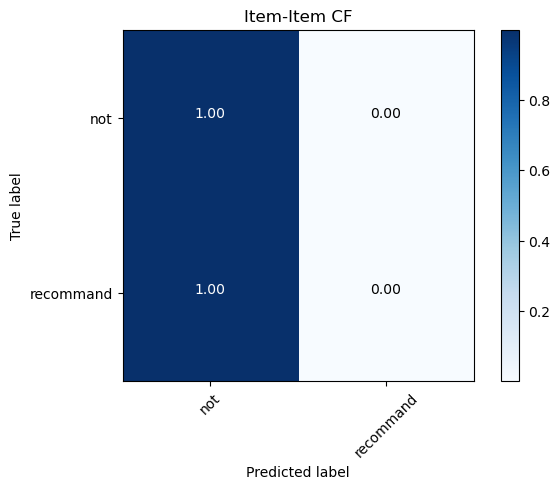

the top10 recommanded products for user 10 is [ 182  201   80  729  595 1093  155  448  996  243]
the real ID is ['B004HOLD4W' 'B001EQ4QJK' 'B001EQ4P2I' 'B000ZSZ5S4' 'B004HOOZEW'
 'B004HOSGWE' 'B001EQ4RBM' 'B001LNTY70' 'B004HOLD60' 'B001KVPBS4']


array([ 182,  201,   80,  729,  595, 1093,  155,  448,  996,  243])

In [103]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MinMaxScaler

def item_item_cf(table=table, distance='cosine'):
    # Calculate item similarity matrix
    item_similarity = pairwise_distances(table.T, metric=distance)

    # Calculate the predicted ratings by combining item similarities with the ratings matrix
    pred_ratings = table.dot(item_similarity) / np.array([np.abs(item_similarity).sum(axis=1)])

    # Scale the predicted ratings to the range of 1-5
    scaler = MinMaxScaler(feature_range=(1, 5))
    pred_ratings_scaled = scaler.fit_transform(pred_ratings)
    
    return pred_ratings_scaled

result = item_item_cf()
caculate_mse(result)
drawcm(result, title='Item-Item CF')
rec(result, 10, 10, rawId=True)


the in sample MSE = 7.907049022696068 
the out sample MSE = 7.881219303033639
caculating cm..
Normalized confusion matrix
[[0.99795752 0.00204248]
 [0.99611273 0.00388727]]


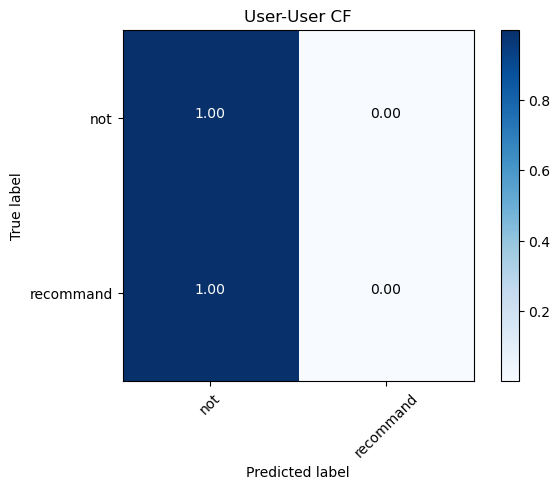

the top10 recommanded products for user 10 is [ 729 1093  243  448  595   80  996  256  201   96]
the real ID is ['B000ZSZ5S4' 'B004HOSGWE' 'B001KVPBS4' 'B001LNTY70' 'B004HOOZEW'
 'B001EQ4P2I' 'B004HOLD60' 'B004HOQE64' 'B001EQ4QJK' 'B004HOLD92']


array([ 729, 1093,  243,  448,  595,   80,  996,  256,  201,   96])

In [102]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MinMaxScaler

def user_user_cf(table=table, distance='cosine'):
    # Calculate user similarity matrix
    user_similarity = pairwise_distances(table, metric=distance)
    
    # Normalize the similarity matrix, making sure diagonal elements are zero
    mean_user_rating = table.mean(axis=1)
    ratings_diff = (table - mean_user_rating[:, np.newaxis])
    
    # Calculate the predicted ratings by combining user similarities with the ratings matrix
    pred_ratings = mean_user_rating[:, np.newaxis] + user_similarity.dot(ratings_diff) / np.array([np.abs(user_similarity).sum(axis=1)]).T

    # Scale the predicted ratings to the range of 1-5
    scaler = MinMaxScaler(feature_range=(1, 5))
    pred_ratings_scaled = scaler.fit_transform(pred_ratings)
    
    return pred_ratings_scaled

result = user_user_cf()
caculate_mse(result)
drawcm(result, title='User-User CF')
rec(result, 10, 10, rawId=True)
